In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import torch
from torch import optim
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, random_split, DataLoader
from tqdm.notebook import tqdm
import pickle as pkl

# Q1

In [2]:
infected_path = "cell_images/Parasitized/"
uninfected_path = "cell_images/Uninfected/"
infected = [infected_path + i for i in os.listdir(infected_path)] 
uninfected = [uninfected_path + i for i in os.listdir(uninfected_path)] 

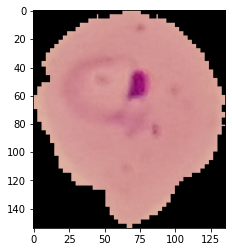

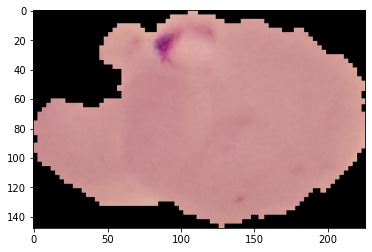

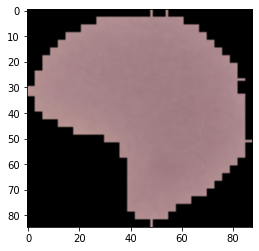

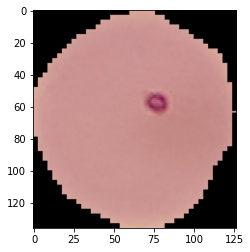

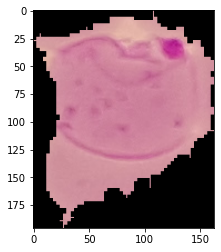

In [111]:
infected_imgs = []
for i in range(5):
    img = random.choice(infected)
    if img in infected_imgs:
        i-=1
    else:
        infected_imgs.append(img)
        im = mpimg.imread(img)
        plt.imshow(im)
        plt.show()

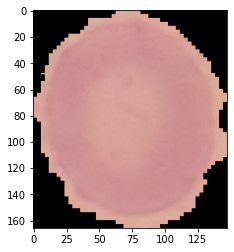

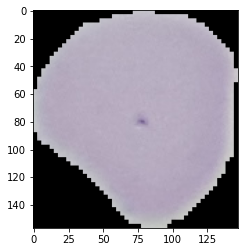

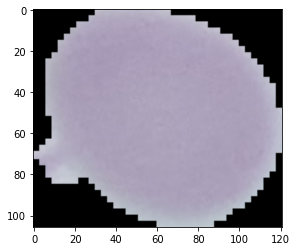

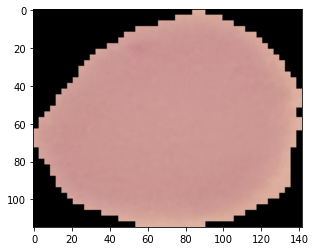

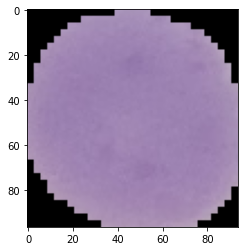

In [4]:
uninfected_imgs = []
for i in range(5):
    img = random.choice(uninfected)
    if img in uninfected_imgs:
        i-=1
    else:
        infected_imgs.append(img)
        im = mpimg.imread(img)
        plt.imshow(im)
        plt.show()

## Dataset


In [5]:
path = "cell_images/"
transform = transforms.Compose([transforms.Resize((128,128),interpolation=transforms.InterpolationMode.NEAREST),
                                       transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
dataset = ImageFolder(path,transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 27558
    Root location: cell_images/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=nearest, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [6]:
torch.manual_seed(1)

In [7]:
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))
train_size = len(dataset)- (val_size+test_size)
train_size,val_size,test_size

(22048, 2755, 2755)

In [8]:
train, val, test = random_split(dataset, [train_size, val_size,test_size])

In [9]:
batch_size = 128
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

# Q2

In [10]:
class Base(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        #images, targets = images.to(device), targets.to(device)
        out = self(images)                      
        loss = F.cross_entropy(out, targets)
        score = accuracy(out, targets)
        return {'loss': loss, 'score': score }
    
    def validation_step(self, batch):
        images, targets = batch 
        #images, targets = images.to(device), targets.to(device)
        out = self(images)                   
        loss = F.cross_entropy(out, targets) 
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_score: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch + 1, result['train_loss'], result['train_score'], result['val_loss'], result['val_score']))

In [114]:
class CNNModel(Base):
    def __init__(self, weight_init = 'none', p = 0.50, dropout = 'none'):  #Dropout : {'conv', 'fcl'}
        super().__init__()
        self.dropout = dropout
        #Weight Initialization
        def set_weights(m):  
            if weight_init == 'zero':
                torch.nn.init.zeros_(m.weight)
                torch.nn.init.zeros_(m.bias)
            elif weight_init == 'he':
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
            elif weight_init =='random':
                torch.nn.init.normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
                
        #BLOCK A
        self.conv_a = nn.Conv2d(3, 16, kernel_size=9, stride=1, padding=2)
        set_weights(self.conv_a)
        self.pool_a = nn.MaxPool2d(kernel_size=2, stride=2)

        #BLOCK B
        self.conv_b = nn.Conv2d(16, 32, kernel_size=6, stride=1, padding=2)
        set_weights(self.conv_b)
        self.pool_b = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        #BLOCK C
        self.conv_c = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        set_weights(self.conv_c)

        #Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fcl = nn.Linear(31*31*64, 2)
        set_weights(self.fcl)
        
        #Dropout
        self.drop = nn.Dropout(p)
        #Sigmoid
        self.sgd = nn.Sigmoid()

    def forward(self, xb):
        out = self.conv_a(xb)
        if(self.dropout == 'conv'):
            out = self.drop(out)
        out = self.pool_a(out)
        out = self.conv_b(out)
        if(self.dropout == 'conv'):
            out = self.drop(out)
        out = self.pool_b(out)
        out = self.conv_c(out)
        if(self.dropout == 'conv'):
            out = self.drop(out)
        out = self.flatten(out)
        out = self.fcl(out)
        if(self.dropout == 'fcl'):
            out = self.drop(out)
        out = self.sgd(out)
        return out

## Helper Functions

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, lmbda = 0, rl = 0):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    try:
        for epoch in range(epochs):
            # Training Phase 
            model.train()
            train_losses = []
            train_scores = []
            for batch in tqdm(train_loader):
                params = torch.cat([x.view(-1) for x in model.fcl.parameters()])
                regularization = torch.tensor(0)
                if rl == 1:
                    regularization = lmbda* torch.norm(params, 1)
                elif rl == 2:
                    regularization = lmbda* torch.norm(params, 2)
                step = model.training_step(batch)
                loss = step['loss'] + regularization
                train_scores.append(step['score'])
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # Validation phase
            result = evaluate(model, val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            result['train_score'] = torch.stack(train_scores).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)
    except:
        pass
    return history

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device

device(type='cpu')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
def plot_losses(history, name):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss') for x in history]
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('graphs\\'+name+'_loss.png')

In [17]:
def plot_accuracies(history, name):
    val_acc = [x['val_score'] for x in history]
    train_acc = [x['train_score'] for x in history]
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('graphs\\'+name+'_acc.png')

In [115]:
num_epochs = 30
opt_func = torch.optim.Adam
lr= 0.0001
demo_model = to_device(CNNModel(), device)
demo_model

CNNModel(
  (conv_a): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (pool_a): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_b): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (pool_b): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv_c): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fcl): Linear(in_features=61504, out_features=2, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (sgd): Sigmoid()
)

In [116]:
history_demo = fit(num_epochs, lr, demo_model, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6085, train_score: 0.6837, val_loss: 0.6014, val_score: 0.6841


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5825, train_score: 0.7141, val_loss: 0.5674, val_score: 0.7375


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5565, train_score: 0.7445, val_loss: 0.5342, val_score: 0.7708


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5226, train_score: 0.7825, val_loss: 0.5213, val_score: 0.7782


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5096, train_score: 0.7934, val_loss: 0.5153, val_score: 0.7846


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4886, train_score: 0.8171, val_loss: 0.4887, val_score: 0.8142


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.4713, train_score: 0.8357, val_loss: 0.4748, val_score: 0.8302


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4591, train_score: 0.8497, val_loss: 0.4844, val_score: 0.8263


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4482, train_score: 0.8616, val_loss: 0.4602, val_score: 0.8496


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4488, train_score: 0.8596, val_loss: 0.4461, val_score: 0.8648


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4419, train_score: 0.8676, val_loss: 0.4470, val_score: 0.8613


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4329, train_score: 0.8769, val_loss: 0.4533, val_score: 0.8588


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4332, train_score: 0.8744, val_loss: 0.4519, val_score: 0.8563


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4385, train_score: 0.8702, val_loss: 0.4333, val_score: 0.8793


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4348, train_score: 0.8735, val_loss: 0.4338, val_score: 0.8799


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4240, train_score: 0.8858, val_loss: 0.4656, val_score: 0.8445


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4262, train_score: 0.8830, val_loss: 0.4436, val_score: 0.8622


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4204, train_score: 0.8890, val_loss: 0.4323, val_score: 0.8793


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4257, train_score: 0.8833, val_loss: 0.4291, val_score: 0.8866


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4210, train_score: 0.8895, val_loss: 0.4197, val_score: 0.8906


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4195, train_score: 0.8902, val_loss: 0.4337, val_score: 0.8750


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4203, train_score: 0.8888, val_loss: 0.4180, val_score: 0.8935


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4170, train_score: 0.8920, val_loss: 0.4163, val_score: 0.8944


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4151, train_score: 0.8959, val_loss: 0.4285, val_score: 0.8756


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4097, train_score: 0.8996, val_loss: 0.4519, val_score: 0.8527


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4135, train_score: 0.8955, val_loss: 0.4169, val_score: 0.8975


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4111, train_score: 0.8975, val_loss: 0.4148, val_score: 0.8933


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4061, train_score: 0.9050, val_loss: 0.4156, val_score: 0.8963


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4041, train_score: 0.9059, val_loss: 0.4158, val_score: 0.8893


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4119, train_score: 0.8984, val_loss: 0.4478, val_score: 0.8549


In [118]:
name = 'demo'
pkl.dump(demo_model, open('models\\'+name, 'wb'))

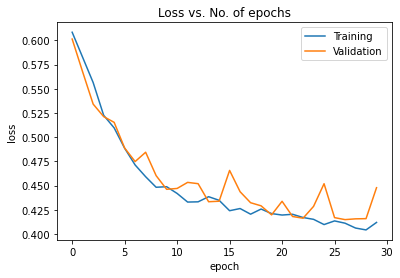

In [119]:
plot_losses(history_demo, name)

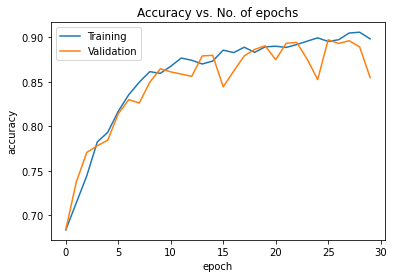

In [120]:
plot_accuracies(history_demo, name)

In [122]:
train_acc = history_demo[-1]['train_score']*100
val_acc = history_demo[-1]['val_score']*100
test_acc = evaluate(demo_model, test_dl)['val_score']*100

In [123]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 89.8392
Validation Accuracy: 85.4866
Test Accuracy: 87.2822


# Q3

In [19]:
num_epochs = 30
opt_func = torch.optim.Adam
lr= 0.0001

### a) Zero Initialization

In [20]:
name = 'zero_init'
model_zero = to_device(CNNModel('zero'), device)
history_zero = fit(num_epochs, lr, model_zero, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6931, train_score: 0.4967, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6931, train_score: 0.4983, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6931, train_score: 0.5014, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6931, train_score: 0.5023, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6931, train_score: 0.5014, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6931, train_score: 0.5014, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6931, train_score: 0.5007, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6931, train_score: 0.5007, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6931, train_score: 0.5016, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6931, train_score: 0.5011, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6931, train_score: 0.5009, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6931, train_score: 0.5020, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6931, train_score: 0.5014, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6931, train_score: 0.5014, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6931, train_score: 0.5014, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6931, train_score: 0.5019, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.6931, train_score: 0.5019, val_loss: 0.6931, val_score: 0.5048


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5048


In [21]:
pkl.dump(model_zero, open('models\\'+name, 'wb'))

In [22]:
history_zero

[{'val_loss': 0.6931460499763489,
  'val_score': 0.5048277378082275,
  'train_loss': 0.6931487321853638,
  'train_score': 0.4967033863067627},
 {'val_loss': 0.6931453347206116,
  'val_score': 0.5048277378082275,
  'train_loss': 0.6931480169296265,
  'train_score': 0.4982839524745941},
 {'val_loss': 0.6931434273719788,
  'val_score': 0.5048277378082275,
  'train_loss': 0.6931477189064026,
  'train_score': 0.5013547539710999},
 {'val_loss': 0.6931427121162415,
  'val_score': 0.5048277378082275,
  'train_loss': 0.6931474804878235,
  'train_score': 0.5012192726135254},
 {'val_loss': 0.6931412816047668,
  'val_score': 0.5048277378082275,
  'train_loss': 0.6931458115577698,
  'train_score': 0.5023031234741211},
 {'val_loss': 0.6931388974189758,
  'val_score': 0.5048277378082275,
  'train_loss': 0.6931467652320862,
  'train_score': 0.5013547539710999},
 {'val_loss': 0.6931393146514893,
  'val_score': 0.5048277378082275,
  'train_loss': 0.6931460499763489,
  'train_score': 0.5013547539710999},

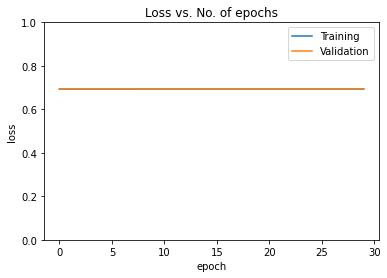

In [23]:
plt.ylim(0,1)
plot_losses(history_zero, name)

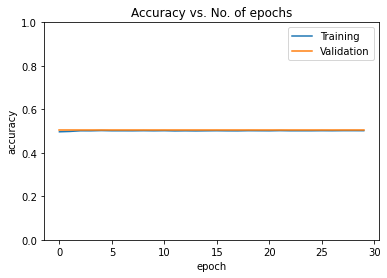

In [24]:
plt.ylim(0,1)
plot_accuracies(history_zero, name)

In [25]:
train_acc = history_zero[-1]['train_score']*100
val_acc = history_zero[-1]['val_score']*100
test_acc = evaluate(model_zero, test_dl)['val_score']*100

In [26]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 50.1761
Validation Accuracy: 50.4828
Test Accuracy: 48.2676


### b) Random Initialization

In [27]:
name = 'rdm_init'
model_rdm = to_device(CNNModel('random'), device)
history_rdm = fit(num_epochs, lr, model_rdm, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7295, train_score: 0.5051, val_loss: 0.7284, val_score: 0.5170


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7271, train_score: 0.5162, val_loss: 0.7330, val_score: 0.5319


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7321, train_score: 0.5273, val_loss: 0.7286, val_score: 0.5389


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7290, train_score: 0.5359, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7287, train_score: 0.5380, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7285, train_score: 0.5383, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7288, train_score: 0.5382, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.7280, train_score: 0.5384, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.7279, train_score: 0.5388, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.7279, train_score: 0.5387, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.7281, train_score: 0.5383, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.7283, train_score: 0.5380, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7285, train_score: 0.5382, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.7283, train_score: 0.5383, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.7285, train_score: 0.5383, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.7281, train_score: 0.5380, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.7280, train_score: 0.5384, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.7277, train_score: 0.5388, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.7280, train_score: 0.5386, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.7288, train_score: 0.5376, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.7289, train_score: 0.5380, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.7289, train_score: 0.5379, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.7283, train_score: 0.5384, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.7286, train_score: 0.5382, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.7285, train_score: 0.5379, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.7285, train_score: 0.5384, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.7284, train_score: 0.5379, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.7285, train_score: 0.5383, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.7284, train_score: 0.5384, val_loss: 0.7281, val_score: 0.5405


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.7286, train_score: 0.5379, val_loss: 0.7281, val_score: 0.5405


In [28]:
pkl.dump(model_rdm, open('models\\'+name, 'wb'))

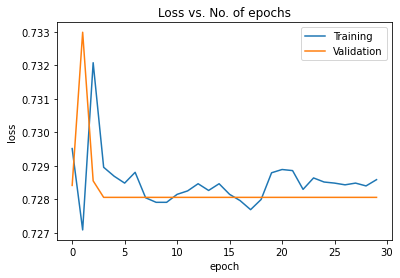

In [29]:
plot_losses(history_rdm, name)

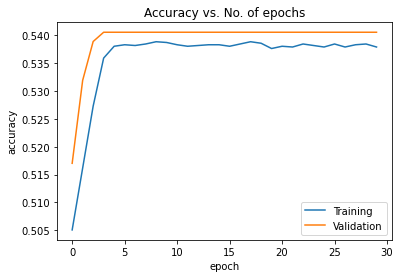

In [30]:
plot_accuracies(history_rdm, name)

In [31]:
train_acc = history_rdm[-1]['train_score']*100
val_acc = history_rdm[-1]['val_score']*100
test_acc = evaluate(model_rdm, test_dl)['val_score']*100

In [32]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 53.7888
Validation Accuracy: 54.0539
Test Accuracy: 55.8541


### c) He Initialization

In [33]:
name = 'he_init'
model_he = to_device(CNNModel('he'), device)
history_he = fit(num_epochs, lr, model_he, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6681, train_score: 0.5727, val_loss: 0.6527, val_score: 0.6058


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6447, train_score: 0.5647, val_loss: 0.6478, val_score: 0.6085


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6375, train_score: 0.5714, val_loss: 0.6366, val_score: 0.5656


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6284, train_score: 0.5483, val_loss: 0.6280, val_score: 0.5544


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6230, train_score: 0.5572, val_loss: 0.6356, val_score: 0.6561


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5695, train_score: 0.6993, val_loss: 0.5533, val_score: 0.7263


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5383, train_score: 0.7482, val_loss: 0.5268, val_score: 0.7649


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5032, train_score: 0.7948, val_loss: 0.5574, val_score: 0.7213


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4949, train_score: 0.8026, val_loss: 0.4932, val_score: 0.8107


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4769, train_score: 0.8242, val_loss: 0.4806, val_score: 0.8195


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4656, train_score: 0.8358, val_loss: 0.4660, val_score: 0.8409


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4534, train_score: 0.8510, val_loss: 0.4640, val_score: 0.8419


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4436, train_score: 0.8612, val_loss: 0.4744, val_score: 0.8348


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4389, train_score: 0.8665, val_loss: 0.4492, val_score: 0.8591


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4371, train_score: 0.8681, val_loss: 0.4489, val_score: 0.8601


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4300, train_score: 0.8762, val_loss: 0.4499, val_score: 0.8570


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4288, train_score: 0.8766, val_loss: 0.4652, val_score: 0.8364


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4278, train_score: 0.8760, val_loss: 0.4482, val_score: 0.8611


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4239, train_score: 0.8799, val_loss: 0.4427, val_score: 0.8647


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4161, train_score: 0.8896, val_loss: 0.4546, val_score: 0.8480


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4188, train_score: 0.8869, val_loss: 0.4401, val_score: 0.8686


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4113, train_score: 0.8950, val_loss: 0.4411, val_score: 0.8620


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4150, train_score: 0.8904, val_loss: 0.4370, val_score: 0.8716


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4120, train_score: 0.8919, val_loss: 0.4346, val_score: 0.8763


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4027, train_score: 0.9021, val_loss: 0.4343, val_score: 0.8735


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4063, train_score: 0.8988, val_loss: 0.4289, val_score: 0.8799


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4055, train_score: 0.8997, val_loss: 0.4348, val_score: 0.8782


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4015, train_score: 0.9030, val_loss: 0.4366, val_score: 0.8682


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4038, train_score: 0.9007, val_loss: 0.4271, val_score: 0.8829


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4025, train_score: 0.9017, val_loss: 0.4624, val_score: 0.8433


In [34]:
pkl.dump(model_he, open('models\\'+name, 'wb'))

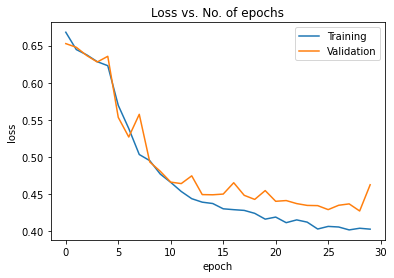

In [35]:
plot_losses(history_he, name)

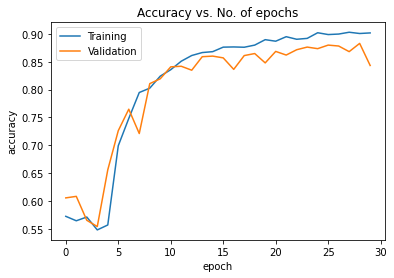

In [36]:
plot_accuracies(history_he, name)

In [37]:
train_acc = history_he[-1]['train_score']*100
val_acc = history_he[-1]['val_score']*100
test_acc = evaluate(model_he, test_dl)['val_score']*100

In [38]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 90.1734
Validation Accuracy: 84.3326
Test Accuracy: 85.3112


# Q4 Dropout

### a) After convolutional layers

Keep probability = 0.25

In [39]:
name = 'a_p25'
model_a_p25 = to_device(CNNModel('he', 0.25, 'conv'), device)
history_a_p25 = fit(num_epochs, lr, model_a_p25, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6937, train_score: 0.6207, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6931, train_score: 0.6203, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6931, train_score: 0.6228, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6931, train_score: 0.6201, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6931, train_score: 0.6216, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6931, train_score: 0.6193, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6931, train_score: 0.6218, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6931, train_score: 0.6196, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6931, train_score: 0.6223, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6931, train_score: 0.6194, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6931, train_score: 0.6200, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6931, train_score: 0.6209, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6931, train_score: 0.6210, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6931, train_score: 0.6227, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6931, train_score: 0.6217, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6931, train_score: 0.6203, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6931, train_score: 0.6240, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6931, train_score: 0.6224, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6931, train_score: 0.6215, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.6931, train_score: 0.6228, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6931, train_score: 0.6202, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6931, train_score: 0.6190, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6931, train_score: 0.6231, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6931, train_score: 0.6224, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6931, train_score: 0.6218, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6931, train_score: 0.6219, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6931, train_score: 0.6208, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6931, train_score: 0.6231, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.6931, train_score: 0.6207, val_loss: 0.6931, val_score: 0.6330


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6931, train_score: 0.6259, val_loss: 0.6931, val_score: 0.6330


In [40]:
pkl.dump(model_a_p25, open('models\\'+name, 'wb'))

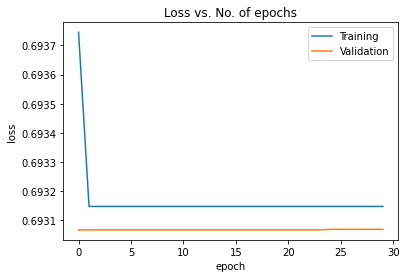

In [41]:
plot_losses(history_a_p25, name)

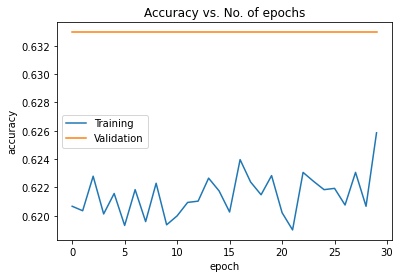

In [42]:
plot_accuracies(history_a_p25, name)

In [43]:
train_acc = history_a_p25[-1]['train_score']*100
val_acc = history_a_p25[-1]['val_score']*100
test_acc = evaluate(model_a_p25, test_dl)['val_score']*100

In [44]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 62.5858
Validation Accuracy: 63.2960
Test Accuracy: 63.6711


Keep probability = 0.50

In [45]:
name = 'a_p50'
model_a_p50 = to_device(CNNModel('he', 0.50, 'conv'), device)
history_a_p50 = fit(num_epochs, lr, model_a_p50, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6942, train_score: 0.5036, val_loss: 0.6931, val_score: 0.6000


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6931, train_score: 0.5014, val_loss: 0.6931, val_score: 0.5993


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6932, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5151


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5151


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6931, train_score: 0.5024, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6931, train_score: 0.5022, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6931, train_score: 0.5016, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6931, train_score: 0.5011, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6931, train_score: 0.5019, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6931, train_score: 0.5020, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6931, train_score: 0.5008, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5155


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.6932, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5246


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6931, train_score: 0.5018, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6931, train_score: 0.5011, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6931, train_score: 0.5008, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6931, train_score: 0.5016, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6931, train_score: 0.5019, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6931, train_score: 0.5019, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.6931, train_score: 0.5012, val_loss: 0.6931, val_score: 0.5741


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6931, train_score: 0.5009, val_loss: 0.6931, val_score: 0.5741


In [46]:
pkl.dump(model_a_p50, open('models\\'+name, 'wb'))

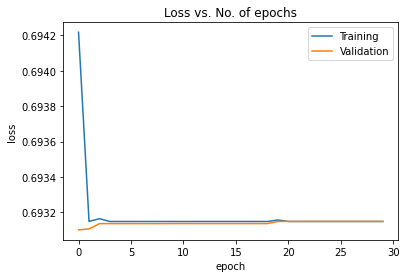

In [47]:
plot_losses(history_a_p50, name)

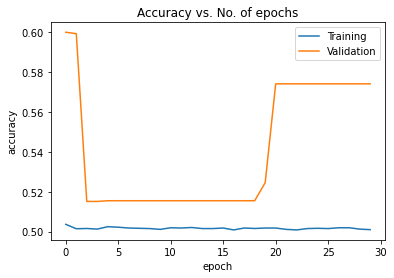

In [48]:
plot_accuracies(history_a_p50, name)

In [49]:
train_acc = history_a_p50[-1]['train_score']*100
val_acc = history_a_p50[-1]['val_score']*100
test_acc = evaluate(model_a_p50, test_dl)['val_score']*100

In [50]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 50.0948
Validation Accuracy: 57.4120
Test Accuracy: 57.5807


Keep probability = 0.75

In [51]:
name = 'a_p75'
model_a_p75 = to_device(CNNModel('he', 0.75, 'conv'), device)
history_a_p75 = fit(num_epochs, lr, model_a_p75, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6980, train_score: 0.5027, val_loss: 0.6907, val_score: 0.5769


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6932, train_score: 0.5019, val_loss: 0.6915, val_score: 0.5516


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6932, train_score: 0.5017, val_loss: 0.6920, val_score: 0.5569


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6931, train_score: 0.5019, val_loss: 0.6919, val_score: 0.5567


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6919, val_score: 0.5432


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6932, train_score: 0.5019, val_loss: 0.6920, val_score: 0.5790


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6931, train_score: 0.5016, val_loss: 0.6920, val_score: 0.5794


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6931, train_score: 0.5003, val_loss: 0.6920, val_score: 0.5794


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6931, train_score: 0.5020, val_loss: 0.6920, val_score: 0.5794


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6931, train_score: 0.5020, val_loss: 0.6920, val_score: 0.5794


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6931, train_score: 0.5015, val_loss: 0.6920, val_score: 0.5791


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6915, train_score: 0.5029, val_loss: 0.6666, val_score: 0.5912


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6825, train_score: 0.5029, val_loss: 0.6752, val_score: 0.5045


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6833, train_score: 0.5011, val_loss: 0.6749, val_score: 0.5046


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6831, train_score: 0.5020, val_loss: 0.6799, val_score: 0.5038


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6745, train_score: 0.5016, val_loss: 0.6746, val_score: 0.5053


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6686, train_score: 0.5018, val_loss: 0.6651, val_score: 0.5044


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6638, train_score: 0.5012, val_loss: 0.6632, val_score: 0.5044


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6646, train_score: 0.5018, val_loss: 0.6722, val_score: 0.5044


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.6793, train_score: 0.5016, val_loss: 0.6611, val_score: 0.5040


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6665, train_score: 0.5011, val_loss: 0.6681, val_score: 0.5033


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6609, train_score: 0.5018, val_loss: 0.6679, val_score: 0.5047


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6585, train_score: 0.5016, val_loss: 0.6695, val_score: 0.5061


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6595, train_score: 0.5011, val_loss: 0.6688, val_score: 0.5058


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6587, train_score: 0.5015, val_loss: 0.6576, val_score: 0.5051


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6598, train_score: 0.5020, val_loss: 0.6761, val_score: 0.5034


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6570, train_score: 0.5020, val_loss: 0.6688, val_score: 0.5044


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6532, train_score: 0.5009, val_loss: 0.6672, val_score: 0.5051


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.6529, train_score: 0.5012, val_loss: 0.6741, val_score: 0.5033


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6506, train_score: 0.5016, val_loss: 0.6533, val_score: 0.5072


In [52]:
pkl.dump(model_a_p75, open('models\\'+name, 'wb'))

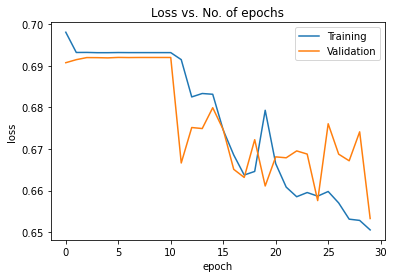

In [53]:
plot_losses(history_a_p75, name)

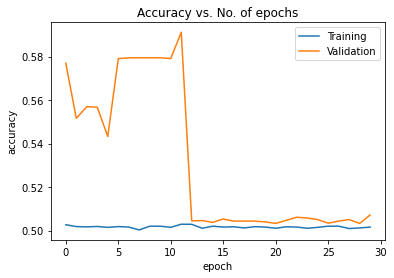

In [54]:
plot_accuracies(history_a_p75, name)

In [55]:
train_acc = history_a_p75[-1]['train_score']*100
val_acc = history_a_p75[-1]['val_score']*100
test_acc = evaluate(model_a_p75, test_dl)['val_score']*100

In [56]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 50.1626
Validation Accuracy: 50.7202
Test Accuracy: 48.4096


### b) Between fully connected layers

Keep probability = 0.25

In [57]:
name = 'b_p25'
model_b_p25 = to_device(CNNModel('he', 0.25, 'fcl'), device)
history_b_p25 = fit(num_epochs, lr, model_b_p25, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6356, train_score: 0.6509, val_loss: 0.5941, val_score: 0.6942


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6125, train_score: 0.6838, val_loss: 0.5971, val_score: 0.6979


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6032, train_score: 0.6975, val_loss: 0.5809, val_score: 0.7143


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5909, train_score: 0.7167, val_loss: 0.5749, val_score: 0.7244


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5763, train_score: 0.7335, val_loss: 0.5474, val_score: 0.7513


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5653, train_score: 0.7461, val_loss: 0.5274, val_score: 0.7736


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5491, train_score: 0.7702, val_loss: 0.5232, val_score: 0.7738


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5336, train_score: 0.7920, val_loss: 0.4984, val_score: 0.8112


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5272, train_score: 0.8003, val_loss: 0.4889, val_score: 0.8150


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5128, train_score: 0.8188, val_loss: 0.4821, val_score: 0.8238


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5088, train_score: 0.8264, val_loss: 0.4881, val_score: 0.8142


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5088, train_score: 0.8250, val_loss: 0.4686, val_score: 0.8420


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5013, train_score: 0.8361, val_loss: 0.4750, val_score: 0.8377


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4901, train_score: 0.8519, val_loss: 0.4566, val_score: 0.8558


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4930, train_score: 0.8476, val_loss: 0.4779, val_score: 0.8278


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4914, train_score: 0.8469, val_loss: 0.4541, val_score: 0.8577


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4835, train_score: 0.8602, val_loss: 0.4556, val_score: 0.8555


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4824, train_score: 0.8602, val_loss: 0.4697, val_score: 0.8309


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4818, train_score: 0.8622, val_loss: 0.5038, val_score: 0.7925


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4783, train_score: 0.8658, val_loss: 0.4477, val_score: 0.8653


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4781, train_score: 0.8666, val_loss: 0.4445, val_score: 0.8633


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4759, train_score: 0.8690, val_loss: 0.4444, val_score: 0.8628


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4726, train_score: 0.8734, val_loss: 0.4523, val_score: 0.8544


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4727, train_score: 0.8733, val_loss: 0.4424, val_score: 0.8637


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4706, train_score: 0.8727, val_loss: 0.4378, val_score: 0.8689


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4646, train_score: 0.8830, val_loss: 0.4351, val_score: 0.8758


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4691, train_score: 0.8750, val_loss: 0.4453, val_score: 0.8616


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4636, train_score: 0.8857, val_loss: 0.4428, val_score: 0.8605


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4617, train_score: 0.8852, val_loss: 0.4288, val_score: 0.8748


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4616, train_score: 0.8839, val_loss: 0.4255, val_score: 0.8817


In [58]:
pkl.dump(model_b_p25, open('models\\'+name, 'wb'))

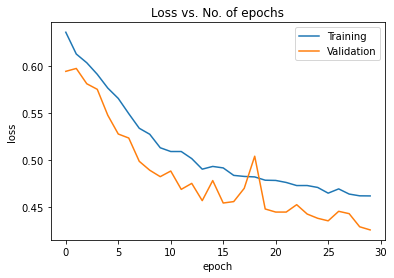

In [59]:
plot_losses(history_b_p25, name)

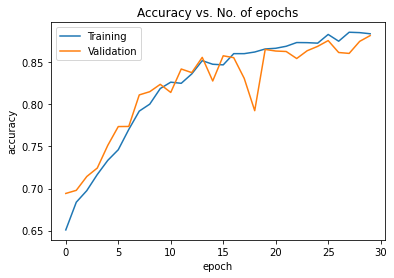

In [60]:
plot_accuracies(history_b_p25, name)

In [61]:
train_acc = history_b_p25[-1]['train_score']*100
val_acc = history_b_p25[-1]['val_score']*100
test_acc = evaluate(model_b_p25, test_dl)['val_score']*100

In [62]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 88.3851
Validation Accuracy: 88.1678
Test Accuracy: 88.8336


Keep probability = 0.50

In [63]:
name = 'b_p50'
model_b_p50 = to_device(CNNModel('he', 0.50, 'fcl'), device)
history_b_p50 = fit(num_epochs, lr, model_b_p50, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6919, train_score: 0.5301, val_loss: 0.6741, val_score: 0.6417


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6876, train_score: 0.5612, val_loss: 0.6587, val_score: 0.6404


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6842, train_score: 0.5654, val_loss: 0.6767, val_score: 0.6055


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6830, train_score: 0.5746, val_loss: 0.6563, val_score: 0.6648


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6815, train_score: 0.5815, val_loss: 0.6745, val_score: 0.6434


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6799, train_score: 0.5845, val_loss: 0.6676, val_score: 0.6488


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6787, train_score: 0.5884, val_loss: 0.6617, val_score: 0.6762


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6808, train_score: 0.5805, val_loss: 0.6621, val_score: 0.6767


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6777, train_score: 0.5896, val_loss: 0.6674, val_score: 0.6746


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6784, train_score: 0.5882, val_loss: 0.6568, val_score: 0.6681


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6755, train_score: 0.5928, val_loss: 0.6813, val_score: 0.6560


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6776, train_score: 0.5861, val_loss: 0.6552, val_score: 0.6850


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6733, train_score: 0.5987, val_loss: 0.6570, val_score: 0.6845


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6804, train_score: 0.5863, val_loss: 0.6562, val_score: 0.6889


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6755, train_score: 0.5918, val_loss: 0.6602, val_score: 0.6793


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6745, train_score: 0.5925, val_loss: 0.6523, val_score: 0.6794


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6758, train_score: 0.5925, val_loss: 0.6532, val_score: 0.6798


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6784, train_score: 0.5902, val_loss: 0.6586, val_score: 0.6782


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6768, train_score: 0.5907, val_loss: 0.6536, val_score: 0.6857


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.6750, train_score: 0.5927, val_loss: 0.6562, val_score: 0.6882


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6766, train_score: 0.5944, val_loss: 0.6572, val_score: 0.6878


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6757, train_score: 0.5942, val_loss: 0.6576, val_score: 0.6811


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6747, train_score: 0.5955, val_loss: 0.6659, val_score: 0.6837


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6795, train_score: 0.5869, val_loss: 0.6549, val_score: 0.6799


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6745, train_score: 0.5948, val_loss: 0.6609, val_score: 0.6841


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6764, train_score: 0.5908, val_loss: 0.6555, val_score: 0.6798


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6759, train_score: 0.5922, val_loss: 0.6542, val_score: 0.6759


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6768, train_score: 0.5860, val_loss: 0.6557, val_score: 0.6752


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.6746, train_score: 0.5931, val_loss: 0.6628, val_score: 0.6857


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6754, train_score: 0.5936, val_loss: 0.6649, val_score: 0.6847


In [64]:
pkl.dump(model_b_p50, open('models\\'+name, 'wb'))

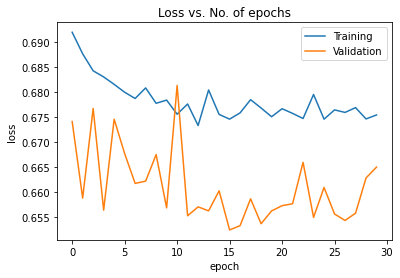

In [65]:
plot_losses(history_b_p50, name)

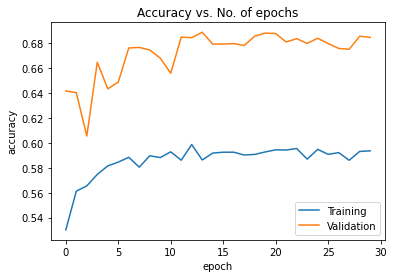

In [66]:
plot_accuracies(history_b_p50, name)

In [67]:
train_acc = history_b_p50[-1]['train_score']*100
val_acc = history_b_p50[-1]['val_score']*100
test_acc = evaluate(model_b_p50, test_dl)['val_score']*100

In [68]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 59.3615
Validation Accuracy: 68.4741
Test Accuracy: 69.4595


Keep probability = 0.75

In [69]:
name = 'b_p75'
model_b_p75 = to_device(CNNModel('he', 0.75, 'fcl'), device)
history_b_p75 = fit(num_epochs, lr, model_b_p75, train_dl, val_dl, opt_func)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6956, train_score: 0.5213, val_loss: 0.6724, val_score: 0.6107


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6835, train_score: 0.5470, val_loss: 0.6543, val_score: 0.6317


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6808, train_score: 0.5516, val_loss: 0.6581, val_score: 0.6470


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6820, train_score: 0.5513, val_loss: 0.6625, val_score: 0.6210


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6801, train_score: 0.5522, val_loss: 0.6466, val_score: 0.6240


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6795, train_score: 0.5552, val_loss: 0.6828, val_score: 0.6027


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6795, train_score: 0.5578, val_loss: 0.6685, val_score: 0.6274


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6777, train_score: 0.5588, val_loss: 0.6544, val_score: 0.6473


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6773, train_score: 0.5594, val_loss: 0.6513, val_score: 0.6386


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6780, train_score: 0.5572, val_loss: 0.6406, val_score: 0.6338


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6794, train_score: 0.5532, val_loss: 0.6630, val_score: 0.6128


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6837, train_score: 0.5434, val_loss: 0.6678, val_score: 0.5947


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6821, train_score: 0.5472, val_loss: 0.6413, val_score: 0.6314


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6764, train_score: 0.5539, val_loss: 0.6488, val_score: 0.6467


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6720, train_score: 0.5700, val_loss: 0.6284, val_score: 0.6560


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6750, train_score: 0.5618, val_loss: 0.6500, val_score: 0.6521


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6711, train_score: 0.5678, val_loss: 0.6314, val_score: 0.6590


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6785, train_score: 0.5555, val_loss: 0.6478, val_score: 0.6528


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6870, train_score: 0.5354, val_loss: 0.6673, val_score: 0.5675


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.6859, train_score: 0.5415, val_loss: 0.6397, val_score: 0.6391


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6793, train_score: 0.5552, val_loss: 0.6571, val_score: 0.6373


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6798, train_score: 0.5552, val_loss: 0.6501, val_score: 0.6219


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6781, train_score: 0.5534, val_loss: 0.6308, val_score: 0.6443


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6777, train_score: 0.5564, val_loss: 0.6352, val_score: 0.6497


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6736, train_score: 0.5643, val_loss: 0.6362, val_score: 0.6573


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6739, train_score: 0.5667, val_loss: 0.6222, val_score: 0.6473


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6779, train_score: 0.5555, val_loss: 0.6411, val_score: 0.6624


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6760, train_score: 0.5620, val_loss: 0.6220, val_score: 0.6651


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.6788, train_score: 0.5539, val_loss: 0.6560, val_score: 0.6208


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6766, train_score: 0.5566, val_loss: 0.6336, val_score: 0.6500


In [70]:
pkl.dump(model_b_p75, open('models\\'+name, 'wb'))

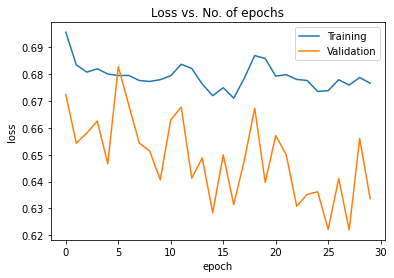

In [71]:
plot_losses(history_b_p75, name)

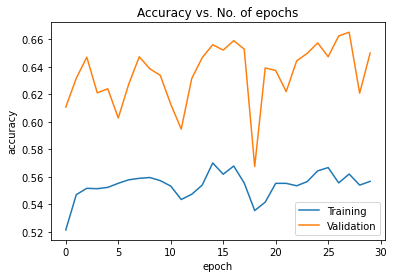

In [72]:
plot_accuracies(history_b_p75, name)

In [73]:
train_acc = history_b_p75[-1]['train_score']*100
val_acc = history_b_p75[-1]['val_score']*100
test_acc = evaluate(model_b_p75, test_dl)['val_score']*100

In [74]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 55.6629
Validation Accuracy: 64.9962
Test Accuracy: 64.3036


# Q5

## a) L1 Regularization

Lambda = 0.001

In [75]:
name = 'l1_001'
rl = 1
lmbda = 0.001
model_l1_001 = to_device(CNNModel('he'), device)
history_l1_001 = fit(num_epochs, lr, model_l1_001, train_dl, val_dl, opt_func, lmbda, rl)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9970, train_score: 0.6026, val_loss: 0.6150, val_score: 0.6666


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7194, train_score: 0.6850, val_loss: 0.6028, val_score: 0.6823


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6591, train_score: 0.6942, val_loss: 0.6306, val_score: 0.6505


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6370, train_score: 0.6993, val_loss: 0.6048, val_score: 0.6856


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6247, train_score: 0.7055, val_loss: 0.5836, val_score: 0.7029


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6130, train_score: 0.7137, val_loss: 0.5778, val_score: 0.7062


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6046, train_score: 0.7262, val_loss: 0.5607, val_score: 0.7395


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5969, train_score: 0.7379, val_loss: 0.5560, val_score: 0.7382


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5901, train_score: 0.7455, val_loss: 0.5796, val_score: 0.7026


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5789, train_score: 0.7611, val_loss: 0.5520, val_score: 0.7428


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5686, train_score: 0.7729, val_loss: 0.5195, val_score: 0.7792


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5564, train_score: 0.7977, val_loss: 0.5238, val_score: 0.7831


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5475, train_score: 0.8106, val_loss: 0.5146, val_score: 0.7695


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5350, train_score: 0.8253, val_loss: 0.4846, val_score: 0.8228


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5272, train_score: 0.8357, val_loss: 0.4843, val_score: 0.8493


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5161, train_score: 0.8482, val_loss: 0.4659, val_score: 0.8645


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5130, train_score: 0.8522, val_loss: 0.4638, val_score: 0.8564


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5117, train_score: 0.8522, val_loss: 0.4571, val_score: 0.8670


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5011, train_score: 0.8631, val_loss: 0.4552, val_score: 0.8552


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4997, train_score: 0.8636, val_loss: 0.4529, val_score: 0.8630


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4964, train_score: 0.8670, val_loss: 0.4443, val_score: 0.8755


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4914, train_score: 0.8703, val_loss: 0.4426, val_score: 0.8817


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4901, train_score: 0.8720, val_loss: 0.4562, val_score: 0.8570


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4899, train_score: 0.8729, val_loss: 0.4438, val_score: 0.8835


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4876, train_score: 0.8736, val_loss: 0.4424, val_score: 0.8708


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4815, train_score: 0.8792, val_loss: 0.4583, val_score: 0.8701


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4834, train_score: 0.8778, val_loss: 0.4610, val_score: 0.8609


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4778, train_score: 0.8826, val_loss: 0.4496, val_score: 0.8570


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4829, train_score: 0.8778, val_loss: 0.4395, val_score: 0.8849


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4804, train_score: 0.8796, val_loss: 0.4367, val_score: 0.8863


In [76]:
pkl.dump(model_l1_001, open('models\\'+name, 'wb'))

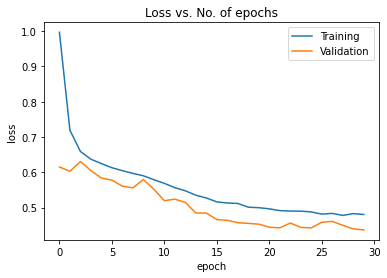

In [77]:
plot_losses(history_l1_001, name)

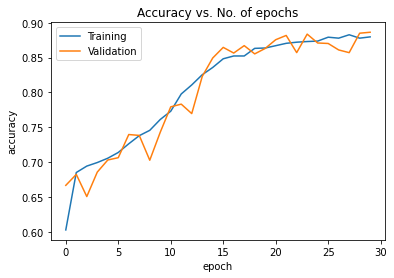

In [78]:
plot_accuracies(history_l1_001, name)

In [79]:
train_acc = history_l1_001[-1]['train_score']*100
val_acc = history_l1_001[-1]['val_score']*100
test_acc = evaluate(model_l1_001, test_dl)['val_score']*100

In [80]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 87.9606
Validation Accuracy: 88.6251
Test Accuracy: 87.6994


Lambda = 0.01

In [81]:
name = 'l1_01'
rl = 1
lmbda = 0.01
model_l1_01 = to_device(CNNModel('he'), device)
history_l1_01 = fit(num_epochs, lr, model_l1_01, train_dl, val_dl, opt_func, lmbda, rl)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.2691, train_score: 0.6436, val_loss: 0.6268, val_score: 0.6489


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7084, train_score: 0.6779, val_loss: 0.6082, val_score: 0.6828


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6564, train_score: 0.6889, val_loss: 0.6086, val_score: 0.6882


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6456, train_score: 0.6908, val_loss: 0.6036, val_score: 0.6915


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6386, train_score: 0.6934, val_loss: 0.6004, val_score: 0.6944


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6338, train_score: 0.6968, val_loss: 0.5978, val_score: 0.6959


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6335, train_score: 0.6947, val_loss: 0.5995, val_score: 0.6956


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6283, train_score: 0.7003, val_loss: 0.5932, val_score: 0.6943


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6284, train_score: 0.6962, val_loss: 0.5960, val_score: 0.6926


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6294, train_score: 0.6976, val_loss: 0.5926, val_score: 0.6919


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6271, train_score: 0.6985, val_loss: 0.5931, val_score: 0.6950


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6249, train_score: 0.7000, val_loss: 0.5941, val_score: 0.6907


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6232, train_score: 0.6995, val_loss: 0.5930, val_score: 0.6906


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6218, train_score: 0.7022, val_loss: 0.5936, val_score: 0.6876


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6232, train_score: 0.7021, val_loss: 0.5891, val_score: 0.6995


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6242, train_score: 0.7029, val_loss: 0.5882, val_score: 0.7007


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6217, train_score: 0.7008, val_loss: 0.5922, val_score: 0.6959


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6224, train_score: 0.7029, val_loss: 0.5905, val_score: 0.6968


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6237, train_score: 0.7037, val_loss: 0.5909, val_score: 0.6955


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.6205, train_score: 0.7048, val_loss: 0.5910, val_score: 0.6889


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6186, train_score: 0.7057, val_loss: 0.5902, val_score: 0.6884


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6187, train_score: 0.7066, val_loss: 0.5852, val_score: 0.6956


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6181, train_score: 0.7085, val_loss: 0.5872, val_score: 0.7003


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6171, train_score: 0.7094, val_loss: 0.5874, val_score: 0.6977


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6176, train_score: 0.7119, val_loss: 0.5836, val_score: 0.7047


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6133, train_score: 0.7211, val_loss: 0.5783, val_score: 0.7083


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.6140, train_score: 0.7256, val_loss: 0.6167, val_score: 0.6607


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.6062, train_score: 0.7428, val_loss: 0.5646, val_score: 0.7201


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.6007, train_score: 0.7528, val_loss: 0.5567, val_score: 0.7375


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.5951, train_score: 0.7584, val_loss: 0.5391, val_score: 0.7674


In [82]:
pkl.dump(model_l1_01, open('models\\'+name, 'wb'))

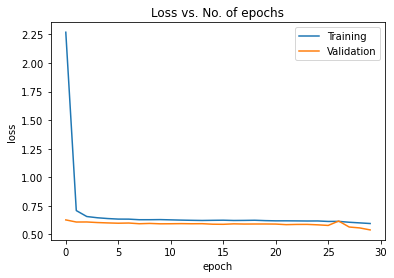

In [83]:
plot_losses(history_l1_01, name)

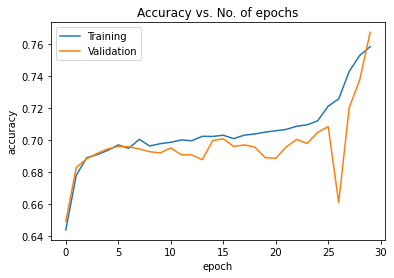

In [84]:
plot_accuracies(history_l1_01, name)

In [85]:
train_acc = history_l1_01[-1]['train_score']*100
val_acc = history_l1_01[-1]['val_score']*100
test_acc = evaluate(model_l1_01, test_dl)['val_score']*100

In [86]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 75.8354
Validation Accuracy: 76.7395
Test Accuracy: 77.2545


Lambda = 0.1

In [87]:
name = 'l1_1'
rl = 1
lmbda = 0.1
model_l1_1 = to_device(CNNModel('he'), device)
history_l1_1 = fit(num_epochs, lr, model_l1_1, train_dl, val_dl, opt_func, lmbda, rl)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 12.9011, train_score: 0.6165, val_loss: 0.6549, val_score: 0.6449


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8614, train_score: 0.6181, val_loss: 0.6338, val_score: 0.6599


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8313, train_score: 0.6556, val_loss: 0.6355, val_score: 0.6315


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8103, train_score: 0.6763, val_loss: 0.6199, val_score: 0.6609


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7989, train_score: 0.6779, val_loss: 0.6140, val_score: 0.6758


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7998, train_score: 0.6804, val_loss: 0.6139, val_score: 0.6851


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7933, train_score: 0.6838, val_loss: 0.6121, val_score: 0.6815


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.7917, train_score: 0.6839, val_loss: 0.6095, val_score: 0.6851


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.7916, train_score: 0.6834, val_loss: 0.6090, val_score: 0.6791


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.7903, train_score: 0.6829, val_loss: 0.6127, val_score: 0.6704


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.7873, train_score: 0.6851, val_loss: 0.6114, val_score: 0.6959


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.7930, train_score: 0.6828, val_loss: 0.6075, val_score: 0.6789


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7878, train_score: 0.6853, val_loss: 0.6062, val_score: 0.6833


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.7945, train_score: 0.6824, val_loss: 0.6062, val_score: 0.6825


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.7876, train_score: 0.6875, val_loss: 0.6209, val_score: 0.6875


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.7937, train_score: 0.6862, val_loss: 0.6087, val_score: 0.6720


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.7885, train_score: 0.6877, val_loss: 0.6053, val_score: 0.6918


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.7884, train_score: 0.6884, val_loss: 0.6173, val_score: 0.6637


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.7902, train_score: 0.6852, val_loss: 0.6107, val_score: 0.6813


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.7877, train_score: 0.6856, val_loss: 0.6034, val_score: 0.6933


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.7874, train_score: 0.6893, val_loss: 0.6074, val_score: 0.6882


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.7896, train_score: 0.6906, val_loss: 0.6048, val_score: 0.6994


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.7883, train_score: 0.6891, val_loss: 0.6233, val_score: 0.6746


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.7862, train_score: 0.6911, val_loss: 0.6074, val_score: 0.6781


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.7879, train_score: 0.6911, val_loss: 0.6141, val_score: 0.6732


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.7914, train_score: 0.6897, val_loss: 0.6073, val_score: 0.6807


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.7930, train_score: 0.6920, val_loss: 0.6269, val_score: 0.6615


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.7857, train_score: 0.6927, val_loss: 0.6029, val_score: 0.6929


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.7881, train_score: 0.6922, val_loss: 0.6068, val_score: 0.6846


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.7897, train_score: 0.6923, val_loss: 0.6117, val_score: 0.6684


In [88]:
pkl.dump(model_l1_1, open('models\\'+name, 'wb'))

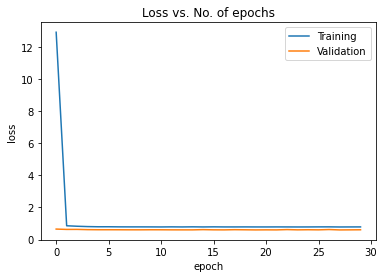

In [89]:
plot_losses(history_l1_1, name)

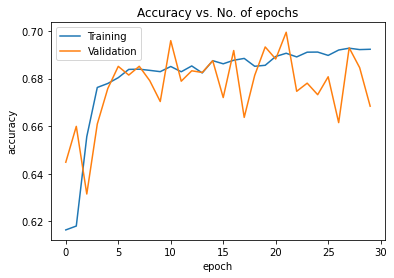

In [90]:
plot_accuracies(history_l1_1, name)

In [91]:
train_acc = history_l1_1[-1]['train_score']*100
val_acc = history_l1_1[-1]['val_score']*100
test_acc = evaluate(model_l1_1, test_dl)['val_score']*100

In [92]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 69.2287
Validation Accuracy: 66.8404
Test Accuracy: 68.0035


## b) L2 Regularization

Lambda = 0.001

In [93]:
name = 'l2_001'
rl = 2
lmbda = 0.001
model_l2_001 = to_device(CNNModel('he'), device)
history_l2_001 = fit(num_epochs, lr, model_l2_001, train_dl, val_dl, opt_func, lmbda, rl)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6195, train_score: 0.6662, val_loss: 0.5939, val_score: 0.6883


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5830, train_score: 0.7122, val_loss: 0.5774, val_score: 0.7066


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5555, train_score: 0.7421, val_loss: 0.5718, val_score: 0.7195


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5330, train_score: 0.7687, val_loss: 0.5458, val_score: 0.7467


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5134, train_score: 0.7910, val_loss: 0.5408, val_score: 0.7603


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4944, train_score: 0.8144, val_loss: 0.5027, val_score: 0.8117


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.4778, train_score: 0.8337, val_loss: 0.4849, val_score: 0.8282


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4676, train_score: 0.8440, val_loss: 0.4770, val_score: 0.8362


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4612, train_score: 0.8521, val_loss: 0.5037, val_score: 0.8031


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4580, train_score: 0.8517, val_loss: 0.4800, val_score: 0.8276


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4500, train_score: 0.8623, val_loss: 0.4694, val_score: 0.8447


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4472, train_score: 0.8645, val_loss: 0.4687, val_score: 0.8417


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4436, train_score: 0.8663, val_loss: 0.4596, val_score: 0.8504


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4352, train_score: 0.8746, val_loss: 0.4577, val_score: 0.8497


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4331, train_score: 0.8772, val_loss: 0.4555, val_score: 0.8449


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4294, train_score: 0.8803, val_loss: 0.4585, val_score: 0.8500


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4317, train_score: 0.8793, val_loss: 0.4458, val_score: 0.8619


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4282, train_score: 0.8811, val_loss: 0.4541, val_score: 0.8548


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4235, train_score: 0.8859, val_loss: 0.4601, val_score: 0.8448


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4225, train_score: 0.8873, val_loss: 0.4464, val_score: 0.8596


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4173, train_score: 0.8932, val_loss: 0.4446, val_score: 0.8617


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4163, train_score: 0.8937, val_loss: 0.4609, val_score: 0.8473


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4200, train_score: 0.8911, val_loss: 0.4529, val_score: 0.8530


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4123, train_score: 0.8966, val_loss: 0.4435, val_score: 0.8625


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4117, train_score: 0.8970, val_loss: 0.4802, val_score: 0.8197


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4210, train_score: 0.8878, val_loss: 0.4483, val_score: 0.8574


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4094, train_score: 0.9002, val_loss: 0.4359, val_score: 0.8687


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4077, train_score: 0.9021, val_loss: 0.4440, val_score: 0.8623


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4025, train_score: 0.9084, val_loss: 0.4315, val_score: 0.8791


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4038, train_score: 0.9069, val_loss: 0.4419, val_score: 0.8667


In [94]:
pkl.dump(model_l2_001, open('models\\'+name, 'wb'))

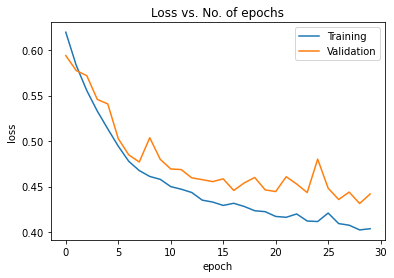

In [95]:
plot_losses(history_l2_001, name)

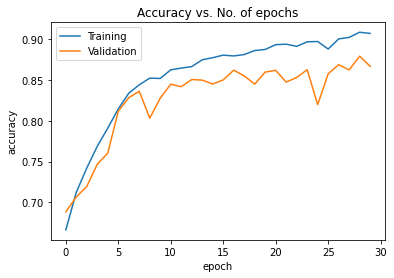

In [96]:
plot_accuracies(history_l2_001, name)

In [97]:
train_acc = history_l2_001[-1]['train_score']*100
val_acc = history_l2_001[-1]['val_score']*100
test_acc = evaluate(model_l2_001, test_dl)['val_score']*100

In [98]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 90.6927
Validation Accuracy: 86.6652
Test Accuracy: 85.5154


Lambda = 0.01

In [99]:
name = 'l2_01'
rl = 2
lmbda = 0.01
model_l2_01 = to_device(CNNModel('he'), device)
history_l2_01 = fit(num_epochs, lr, model_l2_01, train_dl, val_dl, opt_func, lmbda, rl)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6409, train_score: 0.6561, val_loss: 0.6058, val_score: 0.6878


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6064, train_score: 0.6959, val_loss: 0.5924, val_score: 0.6923


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5875, train_score: 0.7202, val_loss: 0.6169, val_score: 0.6409


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5694, train_score: 0.7406, val_loss: 0.5567, val_score: 0.7427


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5409, train_score: 0.7785, val_loss: 0.5593, val_score: 0.7281


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5324, train_score: 0.7863, val_loss: 0.4979, val_score: 0.8067


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5062, train_score: 0.8209, val_loss: 0.4891, val_score: 0.8211


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4989, train_score: 0.8284, val_loss: 0.5540, val_score: 0.7309


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4887, train_score: 0.8421, val_loss: 0.4772, val_score: 0.8319


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4856, train_score: 0.8435, val_loss: 0.5066, val_score: 0.8028


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4790, train_score: 0.8512, val_loss: 0.4646, val_score: 0.8436


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4706, train_score: 0.8605, val_loss: 0.4820, val_score: 0.8272


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4703, train_score: 0.8602, val_loss: 0.4607, val_score: 0.8455


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4646, train_score: 0.8666, val_loss: 0.4521, val_score: 0.8605


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4607, train_score: 0.8702, val_loss: 0.4464, val_score: 0.8658


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4570, train_score: 0.8744, val_loss: 0.4564, val_score: 0.8455


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4540, train_score: 0.8764, val_loss: 0.4483, val_score: 0.8550


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4504, train_score: 0.8815, val_loss: 0.4419, val_score: 0.8742


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4497, train_score: 0.8810, val_loss: 0.4429, val_score: 0.8679


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4510, train_score: 0.8805, val_loss: 0.4580, val_score: 0.8453


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4439, train_score: 0.8858, val_loss: 0.4395, val_score: 0.8706


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4418, train_score: 0.8891, val_loss: 0.4447, val_score: 0.8684


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4447, train_score: 0.8881, val_loss: 0.4451, val_score: 0.8683


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4373, train_score: 0.8943, val_loss: 0.4343, val_score: 0.8739


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4433, train_score: 0.8875, val_loss: 0.4339, val_score: 0.8791


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4346, train_score: 0.8987, val_loss: 0.4356, val_score: 0.8732


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4349, train_score: 0.8982, val_loss: 0.4348, val_score: 0.8778


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4355, train_score: 0.8970, val_loss: 0.4274, val_score: 0.8835


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4307, train_score: 0.9008, val_loss: 0.4293, val_score: 0.8791


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4271, train_score: 0.9040, val_loss: 0.4263, val_score: 0.8812


In [100]:
pkl.dump(model_l2_01, open('models\\'+name, 'wb'))

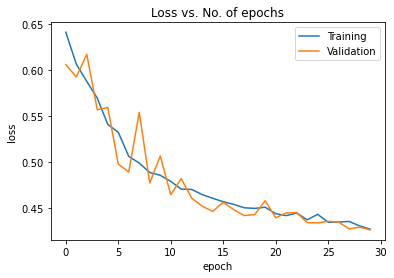

In [101]:
plot_losses(history_l2_01, name)

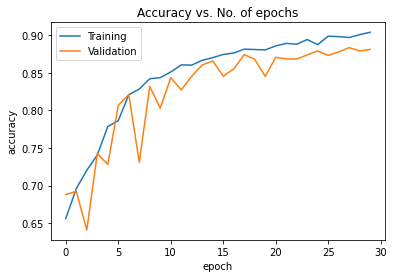

In [102]:
plot_accuracies(history_l2_01, name)

In [103]:
train_acc = history_l2_01[-1]['train_score']*100
val_acc = history_l2_01[-1]['val_score']*100
test_acc = evaluate(model_l2_01, test_dl)['val_score']*100

In [104]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 90.3992
Validation Accuracy: 88.1190
Test Accuracy: 88.3275


Lambda = 0.1

In [105]:
name = 'l2_1'
rl = 2
lmbda = 0.1
model_l2_1 = to_device(CNNModel('he'), device)
history_l2_1 = fit(num_epochs, lr, model_l2_1, train_dl, val_dl, opt_func, lmbda, rl)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.8487, train_score: 0.5065, val_loss: 0.6496, val_score: 0.5305


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7646, train_score: 0.5776, val_loss: 0.6435, val_score: 0.5813


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6856, train_score: 0.6791, val_loss: 0.5906, val_score: 0.6960


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6440, train_score: 0.7082, val_loss: 0.5966, val_score: 0.7031


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6228, train_score: 0.7295, val_loss: 0.5953, val_score: 0.6897


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6087, train_score: 0.7390, val_loss: 0.5481, val_score: 0.7545


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5922, train_score: 0.7622, val_loss: 0.5330, val_score: 0.7675


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5699, train_score: 0.7954, val_loss: 0.5124, val_score: 0.7881


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5714, train_score: 0.7903, val_loss: 0.5149, val_score: 0.7832


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5461, train_score: 0.8235, val_loss: 0.4993, val_score: 0.8058


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5374, train_score: 0.8348, val_loss: 0.4750, val_score: 0.8494


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5301, train_score: 0.8405, val_loss: 0.4799, val_score: 0.8376


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5201, train_score: 0.8533, val_loss: 0.4871, val_score: 0.8399


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5195, train_score: 0.8489, val_loss: 0.4631, val_score: 0.8461


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5122, train_score: 0.8578, val_loss: 0.4635, val_score: 0.8466


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5165, train_score: 0.8523, val_loss: 0.4526, val_score: 0.8633


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5071, train_score: 0.8608, val_loss: 0.4465, val_score: 0.8688


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5035, train_score: 0.8660, val_loss: 0.4599, val_score: 0.8668


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5053, train_score: 0.8614, val_loss: 0.4513, val_score: 0.8694


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.5033, train_score: 0.8630, val_loss: 0.4538, val_score: 0.8540


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4906, train_score: 0.8758, val_loss: 0.4530, val_score: 0.8563


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4887, train_score: 0.8787, val_loss: 0.4514, val_score: 0.8793


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4885, train_score: 0.8760, val_loss: 0.4398, val_score: 0.8851


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4878, train_score: 0.8773, val_loss: 0.4549, val_score: 0.8554


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4839, train_score: 0.8811, val_loss: 0.4386, val_score: 0.8778


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4825, train_score: 0.8815, val_loss: 0.4402, val_score: 0.8688


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4783, train_score: 0.8854, val_loss: 0.4727, val_score: 0.8459


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4764, train_score: 0.8863, val_loss: 0.4461, val_score: 0.8636


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4740, train_score: 0.8903, val_loss: 0.4396, val_score: 0.8857


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4704, train_score: 0.8932, val_loss: 0.4396, val_score: 0.8729


In [106]:
pkl.dump(model_l2_1, open('models\\'+name, 'wb'))

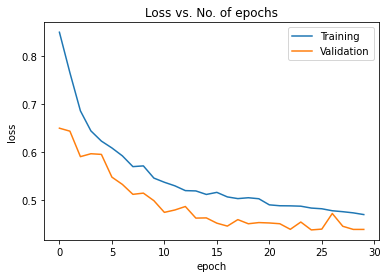

In [107]:
plot_losses(history_l2_1, name)

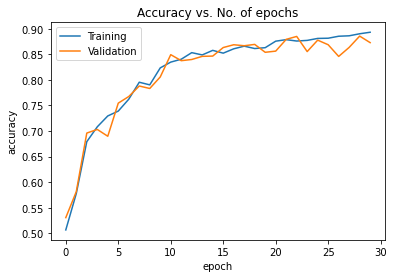

In [108]:
plot_accuracies(history_l2_1, name)

In [109]:
train_acc = history_l2_1[-1]['train_score']*100
val_acc = history_l2_1[-1]['val_score']*100
test_acc = evaluate(model_l2_1, test_dl)['val_score']*100

In [110]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 89.3244
Validation Accuracy: 87.2911
Test Accuracy: 87.8837


### Best model for higher epochs

In [124]:
name = 'best'
rl = 2
lmbda = 0.01
model_best = to_device(CNNModel('he'), device)
history_best = fit(60, lr, model_best, train_dl, val_dl, opt_func, lmbda, rl)

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6326, train_score: 0.6691, val_loss: 0.5958, val_score: 0.6929


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6009, train_score: 0.7074, val_loss: 0.5794, val_score: 0.7024


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5839, train_score: 0.7266, val_loss: 0.5946, val_score: 0.6870


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5575, train_score: 0.7584, val_loss: 0.5477, val_score: 0.7432


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.5427, train_score: 0.7733, val_loss: 0.5227, val_score: 0.7794


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5279, train_score: 0.7918, val_loss: 0.5094, val_score: 0.7814


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5084, train_score: 0.8144, val_loss: 0.4956, val_score: 0.8060


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4978, train_score: 0.8285, val_loss: 0.4927, val_score: 0.8026


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4867, train_score: 0.8420, val_loss: 0.4979, val_score: 0.8002


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4838, train_score: 0.8444, val_loss: 0.4683, val_score: 0.8414


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4815, train_score: 0.8466, val_loss: 0.4685, val_score: 0.8406


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4702, train_score: 0.8607, val_loss: 0.4660, val_score: 0.8432


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4691, train_score: 0.8603, val_loss: 0.4832, val_score: 0.8312


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4673, train_score: 0.8634, val_loss: 0.4579, val_score: 0.8494


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4628, train_score: 0.8692, val_loss: 0.4511, val_score: 0.8590


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4579, train_score: 0.8727, val_loss: 0.4495, val_score: 0.8599


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4537, train_score: 0.8797, val_loss: 0.4497, val_score: 0.8605


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4574, train_score: 0.8739, val_loss: 0.4714, val_score: 0.8342


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4532, train_score: 0.8775, val_loss: 0.4443, val_score: 0.8674


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4486, train_score: 0.8827, val_loss: 0.4410, val_score: 0.8676


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4466, train_score: 0.8856, val_loss: 0.4516, val_score: 0.8533


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4451, train_score: 0.8870, val_loss: 0.4421, val_score: 0.8715


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4374, train_score: 0.8941, val_loss: 0.4386, val_score: 0.8662


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4382, train_score: 0.8945, val_loss: 0.4807, val_score: 0.8184


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4418, train_score: 0.8913, val_loss: 0.4413, val_score: 0.8706


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4373, train_score: 0.8941, val_loss: 0.4359, val_score: 0.8775


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4375, train_score: 0.8948, val_loss: 0.4340, val_score: 0.8803


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4327, train_score: 0.8996, val_loss: 0.4613, val_score: 0.8472


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4345, train_score: 0.8972, val_loss: 0.4303, val_score: 0.8765


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4303, train_score: 0.9025, val_loss: 0.4265, val_score: 0.8826


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.4287, train_score: 0.9059, val_loss: 0.4293, val_score: 0.8799


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.4305, train_score: 0.9026, val_loss: 0.4276, val_score: 0.8876


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.4289, train_score: 0.9036, val_loss: 0.4278, val_score: 0.8814


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.4245, train_score: 0.9086, val_loss: 0.4235, val_score: 0.8862


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.4326, train_score: 0.8997, val_loss: 0.4234, val_score: 0.8895


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.4253, train_score: 0.9078, val_loss: 0.4257, val_score: 0.8871


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.4209, train_score: 0.9114, val_loss: 0.4220, val_score: 0.8885


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.4246, train_score: 0.9094, val_loss: 0.4328, val_score: 0.8787


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.4244, train_score: 0.9096, val_loss: 0.4212, val_score: 0.8880


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.4166, train_score: 0.9179, val_loss: 0.4231, val_score: 0.8874


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.4161, train_score: 0.9180, val_loss: 0.4216, val_score: 0.8929


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.4155, train_score: 0.9194, val_loss: 0.4196, val_score: 0.8945


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.4159, train_score: 0.9188, val_loss: 0.4195, val_score: 0.8906


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.4147, train_score: 0.9202, val_loss: 0.4188, val_score: 0.8980


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.4119, train_score: 0.9234, val_loss: 0.4172, val_score: 0.8940


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.4130, train_score: 0.9217, val_loss: 0.4163, val_score: 0.8937


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.4126, train_score: 0.9226, val_loss: 0.4283, val_score: 0.8817


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.4105, train_score: 0.9241, val_loss: 0.4175, val_score: 0.8935


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.4063, train_score: 0.9300, val_loss: 0.4223, val_score: 0.8888


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.4084, train_score: 0.9280, val_loss: 0.4143, val_score: 0.9013


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.4102, train_score: 0.9266, val_loss: 0.4162, val_score: 0.8946


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.4085, train_score: 0.9277, val_loss: 0.4191, val_score: 0.8887


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.4075, train_score: 0.9282, val_loss: 0.4145, val_score: 0.8954


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.4053, train_score: 0.9316, val_loss: 0.4195, val_score: 0.8914


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.4072, train_score: 0.9307, val_loss: 0.4120, val_score: 0.9000


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.4035, train_score: 0.9332, val_loss: 0.4146, val_score: 0.8943


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.4048, train_score: 0.9322, val_loss: 0.4258, val_score: 0.8883


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.4047, train_score: 0.9322, val_loss: 0.4188, val_score: 0.8914


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.4030, train_score: 0.9357, val_loss: 0.4069, val_score: 0.9014


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [60], train_loss: 0.4001, train_score: 0.9376, val_loss: 0.4092, val_score: 0.9017


In [125]:
pkl.dump(model_best, open('models\\'+name, 'wb'))

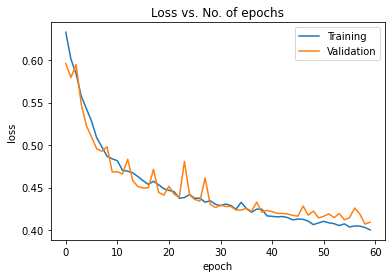

In [126]:
plot_losses(history_best, name)

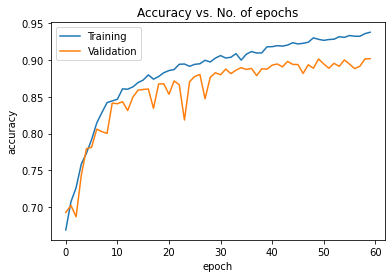

In [127]:
plot_accuracies(history_best, name)

In [128]:
train_acc = history_best[-1]['train_score']*100
val_acc = history_best[-1]['val_score']*100
test_acc = evaluate(model_best, test_dl)['val_score']*100

In [129]:
 print("Train Accuracy: {:.4f}\nValidation Accuracy: {:.4f}\nTest Accuracy: {:.4f}".format(
          train_acc, val_acc, test_acc))

Train Accuracy: 93.7635
Validation Accuracy: 90.1743
Test Accuracy: 90.1231


# Load model

In [ ]:
filename = 'models/best'
loaded_model = pkl.load(open(filename, 'rb'))

In [ ]:
test_acc = evaluate(loaded_mode, test_dl)['val_score']*100
test_acc